# Training from merged origin
Here documents obtained with retrieval and bm25 two document origins are merged into a single dictionary of question-documents in the original bioASQ format:
- CEMB+BM25 generated from original training documents.
- CEMB+BM25 generated from elastic documents extracted for training questions.

## Imports

In [37]:
%load_ext autoreload
%autoreload 2

import logging
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

from src.cemb_bm25 import centroid_retrieval
from src.elastic_search_utils.elastic_utils import load_json, save_json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params

In [38]:
LOADING_ORIGINAL_DOCUMENTS_PATH = '/datasets/johan_tests_original_format/training_docs_10b.json'
LOADING_QUERIED_DOCUMENTS_PATH = '/datasets/johan_tests_original_format/queried_docs_10b.json'

ABSTRACT_WEIGHT = 0.7
TITLE_WEIGHT = 0.3

## Saving directions

In [3]:
SAVING_FOLDER = '/datasets/johan_tests_original_format_centroid/merged_training_docs/'

SAVING_ABSTRACT_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_abstract_model_10b_train.bin'
SAVING_TITLE_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_title_model_10b_train.bin'
SAVING_QUESTION_W2V_PATH = f'{SAVING_FOLDER}/Bio_Word2Vec_doc_question_model_10b_train.bin'

SAVING_ORIGINAL_PATH = f'{SAVING_FOLDER}/training_original_10b.json'
SAVING_TOKENS_PATH = f'{SAVING_FOLDER}/training_tokens_10b.json'
SAVING_CLEANED_PATH = f'{SAVING_FOLDER}/training_cleaned_10b.json'

## Constants

In [4]:
original_questions = load_json(LOADING_ORIGINAL_DOCUMENTS_PATH)

In [5]:
queried_questions = load_json(LOADING_QUERIED_DOCUMENTS_PATH)

## Merging origins into single dictionary

In [6]:
merged_questions = centroid_retrieval.merge_origins(
    original_questions['questions'],
    queried_questions['questions']
)

merging dictionaries: 4234it [00:03, 1151.55it/s]


## Extracting tokens for valid documents
Only documents with abstract will be kept.

One dict cleaned-tokenized, another only cleaned.

In [7]:
tokenized_unique_docs, cleaned_unique_docs = centroid_retrieval.extract_unique_doc_info(
    questions=merged_questions['questions']
)

Extracting unique doc info: 100%|███████████| 4234/4234 [02:55<00:00, 24.11it/s]


## Tokenize question body and replace documents with tokenized documents

In [8]:
tokenized_questions, question_solving_doc_ids = centroid_retrieval.select_questions_useful_documents(
    questions=merged_questions['questions'],
    unique_docs=tokenized_unique_docs,
    use_tokens=True
)

Selecting useful documents: 100%|██████████| 4234/4234 [00:27<00:00, 156.25it/s]


In [9]:
tokenized_questions = {'questions': tokenized_questions}

## Clean question body and replace documents with cleaned documents

In [10]:
cleaned_questions, _ = centroid_retrieval.select_questions_useful_documents(
    questions=merged_questions['questions'],
    unique_docs=cleaned_unique_docs,
    use_tokens=False
)

Selecting useful documents: 100%|██████████| 4234/4234 [00:26<00:00, 159.99it/s]


In [11]:
cleaned_questions = {'questions': cleaned_questions}

## Extracting unique tokenized abstracts and titles for word2vec

In [12]:
unique_abstract_tokens, unique_title_tokens = centroid_retrieval.extract_unique_titles_and_abstracts(
    tokenized_unique_docs=tokenized_unique_docs,
    question_solving_doc_ids=question_solving_doc_ids
)

In [13]:
len(unique_abstract_tokens), len(unique_title_tokens)

(324189, 324189)

In [14]:
len(list(unique_abstract_tokens.values())[0]), len(list(unique_title_tokens.values())[0])

(152, 11)

## Extracting unique tokenized questions for word2vec

In [15]:
unique_question_tokens = centroid_retrieval.extract_unique_questions(
    tokenized_questions['questions']
)

In [16]:
len(unique_question_tokens)

4234

In [17]:
len(list(unique_question_tokens.values())[0])

9

## Making fit models w2vec models for questions, titles and abstracts

In [18]:
question_w2vec_model, question_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_question_tokens.values())

Word2Vec vocabulary length: 6671


In [19]:
abstract_w2vec_model, abstract_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_abstract_tokens.values())

Word2Vec vocabulary length: 517721


In [20]:
title_w2vec_model, title_w2vec_vocab = centroid_retrieval.fit_bio_w2vec(unique_title_tokens.values())

Word2Vec vocabulary length: 135807


## Saving models into disk

In [21]:
question_w2vec_model.save(SAVING_QUESTION_W2V_PATH)

In [22]:
abstract_w2vec_model.save(SAVING_ABSTRACT_W2V_PATH)

In [23]:
title_w2vec_model.save(SAVING_TITLE_W2V_PATH)

## Calculating centroids

In [24]:
question_centroids = centroid_retrieval.calculate_centroids(
    text_tokens=unique_question_tokens,
    model=question_w2vec_model,
    vocab=question_w2vec_vocab
)

Extracting centroids: 100%|██████████████| 4234/4234 [00:00<00:00, 47951.21it/s]


In [25]:
abstract_centroids = centroid_retrieval.calculate_centroids(
    text_tokens=unique_abstract_tokens,
    model=abstract_w2vec_model,
    vocab=abstract_w2vec_vocab
)

Extracting centroids: 100%|███████████| 324189/324189 [01:01<00:00, 5233.99it/s]


In [26]:
title_centroids = centroid_retrieval.calculate_centroids(
    text_tokens=unique_title_tokens,
    model=title_w2vec_model,
    vocab=title_w2vec_vocab
)

Extracting centroids:   1%|▏           | 4133/324189 [00:00<00:07, 41324.52it/s]/datasets/anaconda3/envs/tf2.8/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datasets/anaconda3/envs/tf2.8/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Extracting centroids: 100%|██████████| 324189/324189 [00:08<00:00, 40424.36it/s]


## Calculating question cosine similarities to answers

In [27]:
question_similarities = centroid_retrieval.calculate_question_answer_similarity(
    tokenized_questions=tokenized_questions['questions'],
    question_centroids=question_centroids,
    abstract_centroids=abstract_centroids,
    title_centroids=title_centroids
)

Calculating cosine similarity: 100%|███████| 4234/4234 [00:06<00:00, 689.62it/s]


## Calculating document scores for questions

In [28]:
question_scores = centroid_retrieval.calculate_centroid_score(
    questions_similarities=question_similarities['questions'],
    abstract_weight=ABSTRACT_WEIGHT,
    title_weight=TITLE_WEIGHT
)

Calculating centroid distance: 100%|██████| 4234/4234 [00:00<00:00, 4731.94it/s]


## Selecting useful documents only from original question dictionaries
### Original dict (for Andres model)

In [29]:
centroid_retrieval.update_question_scores_from_raw_data(
    raw_questions=merged_questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█| 4234/4234 [00:00<00:00, 14871.


In [30]:
centroid_retrieval.update_question_scores(
    raw_questions=tokenized_questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█| 4234/4234 [00:00<00:00, 17596.


In [31]:
centroid_retrieval.update_question_scores(
    raw_questions=cleaned_questions['questions'],
    question_scores=question_scores
)

Updating dictionary with centroid scores: 100%|█| 4234/4234 [00:00<00:00, 17216.


## Saving into disk

In [32]:
save_json(merged_questions, SAVING_ORIGINAL_PATH)

In [33]:
save_json(tokenized_questions, SAVING_TOKENS_PATH)

In [34]:
save_json(cleaned_questions, SAVING_CLEANED_PATH)

## Plotting distribution of number of documents

In [35]:
len_docs = [len(question['documents']) for question in merged_questions['questions']]

<AxesSubplot:>

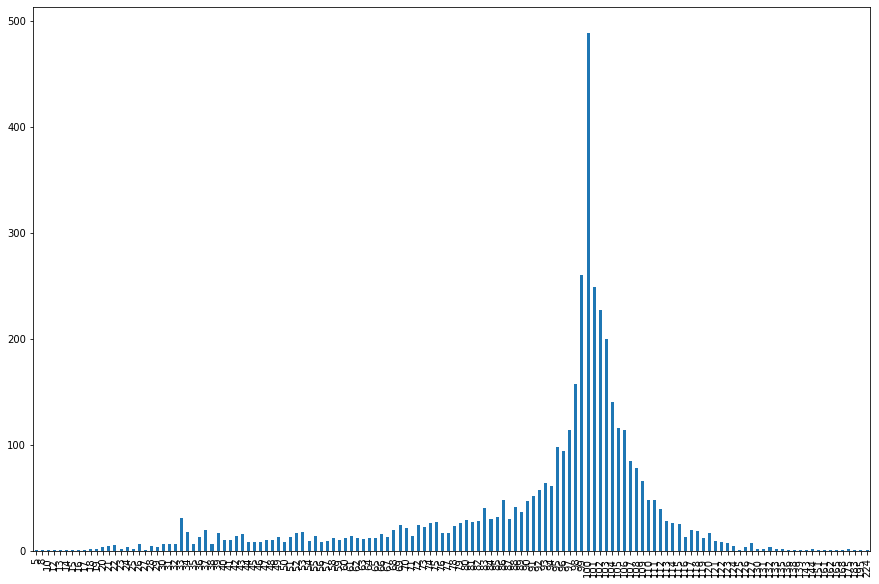

In [36]:
pd.value_counts(len_docs).sort_index().plot(kind='bar', figsize=(15,10))